In [1]:
import glob
import librosa
import librosa.display
from matplotlib import pyplot as plt
import numpy as np
import os
import scipy


subfolders = ["DCASE2013-pcen", "BirdVox-pcen", "SONYC-pcen"]
data_dir = '/beegfs/vl1019/spl2018_datasets'

%matplotlib inline

settings = {
    "fmin": 50,
    "fmax": 10000,
    "hop_length": 512,
    "n_fft": 2048,
    "n_mels": 128,
    "sr": 22050,
    "win_length": 1024,
    "window": "hann",
    "T": 0.023,
    "alpha": 0.96,
    "delta": 2.0,
    "r": 0.5,
    "eps": 1e-10}


figsize = (4, 12)


for subfolder_id in range(len(subfolders)):
    print(subfolder_id)
    
    
    log_E_list = []
    EoverM_list = []
    EoverMplusEps_list = []
    G_list = []
    BC_list = []
    PCEN_list = []


    subfolder_str = subfolders[subfolder_id]
    subfolder_dir = os.path.join(data_dir, subfolder_str)
    wav_names = list(glob.glob(os.path.join(subfolder_dir, "*.wav")))
    wav_paths = sorted([os.path.join(subfolder_dir, x) for x in wav_names])
    n_files = len(wav_paths)

    for file_id in range(n_files):
        wav_path = wav_paths[file_id]
        waveform, fs = librosa.load(wav_path, sr=22050)

        # Compute Short-Term Fourier Transform (STFT).
        stft = librosa.stft(
            waveform,
            n_fft=settings["n_fft"],
            win_length=settings["win_length"],
            hop_length=settings["hop_length"],
            window=settings["window"])


        # Compute squared magnitude coefficients.
        abs2_stft = (stft.real*stft.real) + (stft.imag*stft.imag)


        # Gather frequency bins according to the Mel scale.
        E = librosa.feature.melspectrogram(
            y=None,
            S=abs2_stft,
            sr=settings["sr"],
            n_fft=settings["n_fft"],
            n_mels=settings["n_mels"],
            htk=True,
            fmin=settings["fmin"],
            fmax=settings["fmax"])       
        
        PCEN = librosa.pcen(
            S=E,
            time_constant=settings["T"],
            sr=settings["sr"],
            hop_length=settings["hop_length"],
            gain=settings["alpha"],
            power=settings["r"],
            bias=settings["delta"],
            eps=settings["eps"])

        E_ravel = E.ravel()
        log_E_ravel = np.log(E_ravel)
        PCEN_ravel = PCEN.ravel()

        log_E_list.append(log_E_ravel)
        PCEN_list.append(PCEN_ravel)


    log_E_ravel = np.concatenate(log_E_list)
    PCEN_ravel = np.concatenate(PCEN_list) 

0
1
2


KeyboardInterrupt: 

In [1]:
import glob
import librosa
import librosa.display
from matplotlib import pyplot as plt
import numpy as np
import os
import scipy


subfolders = ["DCASE2013-pcen", "BirdVox-pcen", "SONYC-pcen"]
data_dir = '/beegfs/vl1019/spl2018_datasets'

%matplotlib inline

settings = {
    "fmin": 50,
    "fmax": 10000,
    "hop_length": 512,
    "n_fft": 2048,
    "n_mels": 128,
    "sr": 22050,
    "win_length": 1024,
    "window": "hann",
    "T": 0.023,
    "alpha": 0.96,
    "delta": 2.0,
    "r": 0.5,
    "eps": 1e-10}

In [ ]:
for subfolder_id in range(len(subfolders)):

    logE_list = []
    PCEN_list = []

    subfolder_str = subfolders[subfolder_id]
    subfolder_dir = os.path.join(data_dir, subfolder_str)
    wav_names = list(glob.glob(os.path.join(subfolder_dir, "*.wav")))
    wav_paths = sorted([os.path.join(subfolder_dir, x) for x in wav_names])
    n_files = len(wav_paths)

    for file_id in range(n_files):
        wav_path = wav_paths[file_id]
        waveform, fs = librosa.load(wav_path, sr=22050)

        # Compute Short-Term Fourier Transform (STFT).
        stft = librosa.stft(
            waveform,
            n_fft=settings["n_fft"],
            win_length=settings["win_length"],
            hop_length=settings["hop_length"],
            window=settings["window"])


        # Compute squared magnitude coefficients.
        abs2_stft = (stft.real*stft.real) + (stft.imag*stft.imag)


        # Gather frequency bins according to the Mel scale.
        E = librosa.feature.melspectrogram(
            y=None,
            S=abs2_stft,
            sr=settings["sr"],
            n_fft=settings["n_fft"],
            n_mels=settings["n_mels"],
            htk=True,
            fmin=settings["fmin"],
            fmax=settings["fmax"])       

        PCEN = librosa.pcen(
            S=E,
            time_constant=settings["T"],
            sr=settings["sr"],
            hop_length=settings["hop_length"],
            gain=settings["alpha"],
            power=settings["r"],
            bias=settings["delta"],
            eps=settings["eps"])

        logE_list.append(np.log(E))
        PCEN_list.append(PCEN)

    logE = np.concatenate(logE_list, axis=1)
    PCEN = np.concatenate(PCEN_list, axis=1)
    
    logE_bn = (logE - np.mean(logE)) / np.std(logE)
    PCEN_bn = (PCEN - np.mean(PCEN)) / np.std(PCEN)

    fig = plt.figure()
    plt.imshow((np.abs(np.cov(logE_bn))), cmap="magma_r", vmin=0.0, vmax=1.0)
    plt.tick_params(
        labelleft="off", left="off",
        labelbottom="off", bottom="off")
    fig.savefig(subfolder_str + '_logE_covariance_nolog.eps',
        transparent=True, bbox_inches="tight")

    fig = plt.figure()
    plt.imshow((np.abs(np.cov(PCEN_bn))), cmap="magma_r", vmin=0.0, vmax=1.0)
    plt.tick_params(
        labelleft="off", left="off",
        labelbottom="off", bottom="off")
    fig.savefig(subfolder_str + '_PCEN_covariance_nolog.eps',
        transparent=True, bbox_inches="tight")

In [86]:
logE_bn = (logE - np.mean(logE)) / np.std(logE)
PCEN_bn = (PCEN - np.mean(PCEN)) / np.std(PCEN)

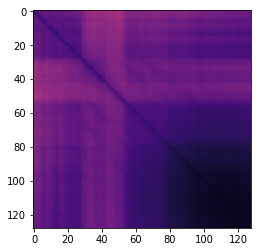

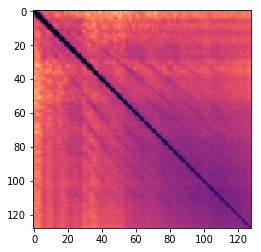

In [98]:
%matplotlib inline
plt.figure()
plt.imshow(np.log10(np.abs(np.cov(logE_bn))), cmap="magma_r", vmin=np.log10(0.02), vmax=0.0)

plt.figure()
plt.imshow(np.log10(np.abs(np.cov(PCEN_bn))), cmap="magma_r", vmin=np.log10(0.02), vmax=0.0)

In [91]:
np.min(np.log10(np.abs(np.cov(PCEN_bn))))

-1.5165032336578115

In [96]:
np.log10(0.05)

-1.3010299956639813